In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset

 95% 189M/199M [00:01<00:00, 163MB/s]
100% 199M/199M [00:01<00:00, 163MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/iqothnccd-lung-cancer-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB7
from keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# Defining paths
data_dir = '/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
train_dir = '/content/train'
test_dir = '/content/test'
val_dir = '/content/val'

# Making directories for train, test, and validation
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
import shutil

# Moving files to corresponding folders
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)

    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        num_files = len(files)

        # Determine split sizes
        train_split = int(num_files * 0.7)
        val_split = int(num_files * 0.15)

        # Shuffle files
        random.shuffle(files)

        # Move files to train folder
        for file in files[:train_split]:
            src = os.path.join(folder_path, file)
            dst = os.path.join(train_dir, folder, file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        # Move files to test folder
        for file in files[train_split:train_split + val_split]:
            src = os.path.join(folder_path, file)
            dst = os.path.join(val_dir, folder, file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        # Move files to validation folder
        for file in files[train_split + val_split:]:
            src = os.path.join(folder_path, file)
            dst = os.path.join(test_dir, folder, file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

In [ ]:
# Function to count files in each folder
def count_files(directory):
    count = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        count[folder] = len(os.listdir(folder_path))
    return count

# Count files in train, test, and validation folders
train_count = count_files(train_dir)
test_count = count_files(test_dir)
val_count = count_files(val_dir)

print("Train count:", train_count)
print("Test count:", test_count)
print("Validation count:", val_count)

Train count: {'Bengin cases': 84, 'Normal cases': 291, 'Malignant cases': 392}
Test count: {'Bengin cases': 18, 'Normal cases': 63, 'Malignant cases': 85}
Validation count: {'Bengin cases': 18, 'Normal cases': 62, 'Malignant cases': 84}


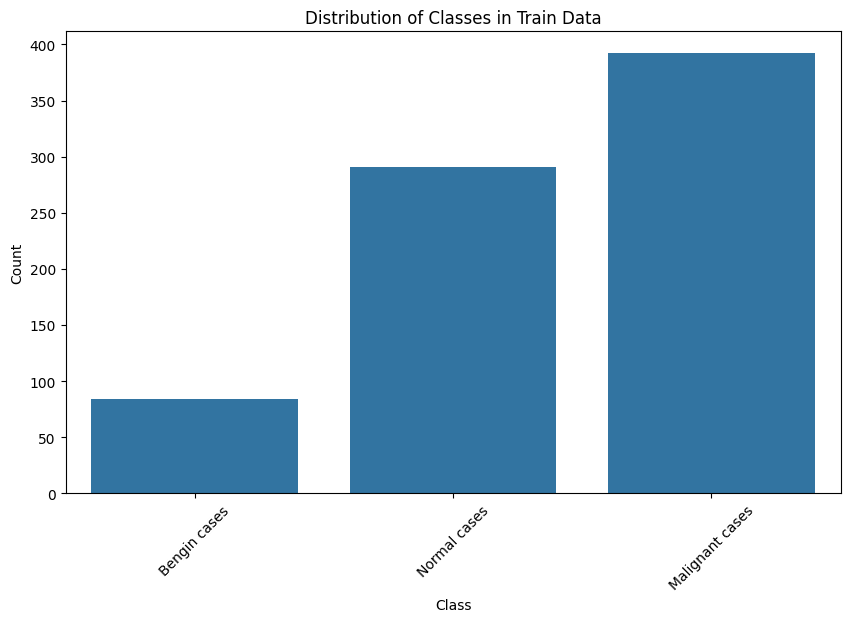

In [ ]:
# Plot distribution of classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_count.keys()), y=list(train_count.values()))
plt.title('Distribution of Classes in Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
###### MAX ELEMENT = 392 ###############
import cv2
import os
import numpy as np
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

# Function to perform elastic transformation
def elastic_transform_opencv(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]

    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3

    original_points = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size], center_square - square_size])
    transform_points = original_points + random_state.uniform(-alpha_affine, alpha_affine, size=original_points.shape).astype(np.float32)

    M = cv2.getAffineTransform(original_points, transform_points)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    return map_coordinates(image, indices, order=3, mode='wrap').reshape(shape)

# Define augmentation parameters
elastic_alpha = 0.2
elastic_sigma = 0.05
elastic_alpha_affine = 0.05

# Define input and output paths for train folder
train_output_dir = "/content/train"

# Calculate maximum number of samples among all classes in train folder
max_samples = max(len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name)))







# Apply elastic transformation to balance classes in train folder
for class_name in os.listdir(train_dir):
    input_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(input_path):  # Skip non-directory entries
        continue

    output_path = os.path.join(train_output_dir, class_name)
    os.makedirs(output_path, exist_ok=True)

    # Calculate the number of images needed for this class
    if class_name == "Bengin cases":
        max_images_needed = 392
    elif class_name == "Malignant cases":
        max_images_needed = 392
    elif class_name == "Normal cases":
        max_images_needed = 392
    else:
        continue  # Skip unknown classes

    # Count the number of images already in the class directory
    existing_images_count = len(os.listdir(output_path))

    # If the class already has enough images, skip augmentation
    if existing_images_count >= max_images_needed:
        continue

    # Calculate the remaining number of images needed
    images_to_generate = max_images_needed - existing_images_count

    # Count the number of transformed images generated for the current class
    num_transformed_images = 0

    # Iterate through each image in the class
    for file in os.listdir(input_path):
        if file.endswith(".jpg"):
            # Load image
            input_image_path = os.path.join(input_path, file)
            image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

            # Apply elastic transformation until the remaining number of samples reaches zero
            while num_transformed_images < images_to_generate:
                # Generate transformed image
                transformed_image = elastic_transform_opencv(image, elastic_alpha * image.shape[0], elastic_sigma * image.shape[0], elastic_alpha_affine * image.shape[0])

                # Save transformed image
                output_file = file.split('.')[0] + f"_{num_transformed_images + existing_images_count}.jpg"
                output_image_path = os.path.join(output_path, output_file)
                cv2.imwrite(output_image_path, transformed_image)

                # Increment the count of transformed images
                num_transformed_images += 1

                # Break the loop if the remaining number of images reaches zero
                if num_transformed_images >= images_to_generate:
                    break


In [ ]:
# Dictionary to store the counts of images in each class
image_counts = {}

# Iterate through each class folder in train_output_dir
for class_name in os.listdir(train_output_dir):
    class_path = os.path.join(train_output_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of files in the class folder
        num_images = len([file for file in os.listdir(class_path) if file.endswith('.jpg')])
        # Store the count in the dictionary
        image_counts[class_name] = num_images

# Print the counts
print("Image Counts after augmentation:")
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")


Image Counts after augmentation:
Bengin cases: 392
Normal cases: 392
Malignant cases: 392


Train count: {'Bengin cases': 392, 'Normal cases': 392, 'Malignant cases': 392}
Test count: {'Bengin cases': 18, 'Normal cases': 63, 'Malignant cases': 85}
Validation count: {'Bengin cases': 18, 'Normal cases': 62, 'Malignant cases': 84}


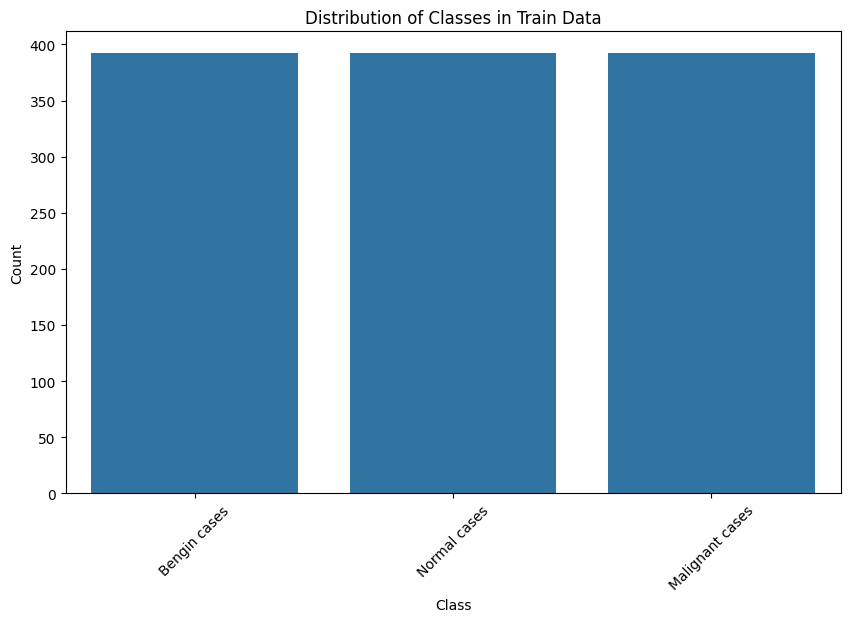

In [ ]:
# Function to count files in each folder
def count_files(directory):
    count = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):  # Check if it's a directory
            count[folder] = len(os.listdir(folder_path))
    return count

# Count files in train, test, and validation folders
train_count = count_files(train_output_dir)
test_count = count_files(test_dir)
val_count = count_files(val_dir)

print("Train count:", train_count)
print("Test count:", test_count)
print("Validation count:", val_count)


# Plot distribution of classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_count.keys()), y=list(train_count.values()))
plt.title('Distribution of Classes in Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

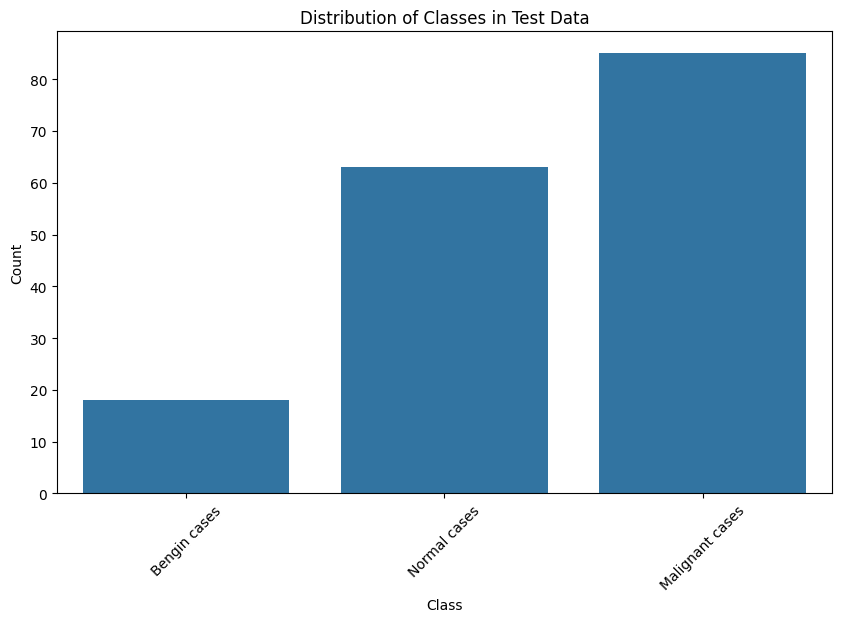

In [ ]:
# Plot distribution of classes in test data
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_count.keys()), y=list(test_count.values()))
plt.title('Distribution of Classes in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

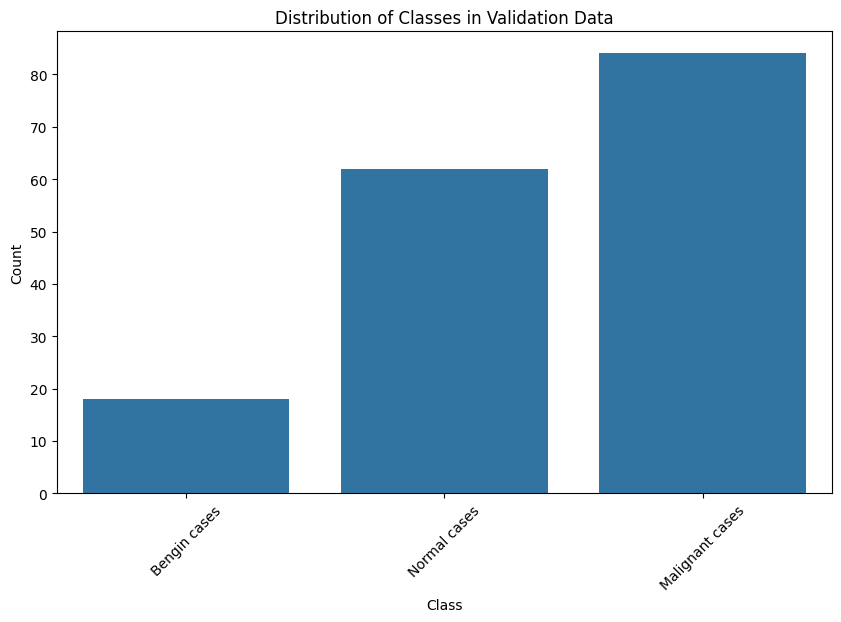

In [ ]:
# Plot distribution of classes in validation data
plt.figure(figsize=(10, 6))
sns.barplot(x=list(val_count.keys()), y=list(val_count.values()))
plt.title('Distribution of Classes in Validation Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

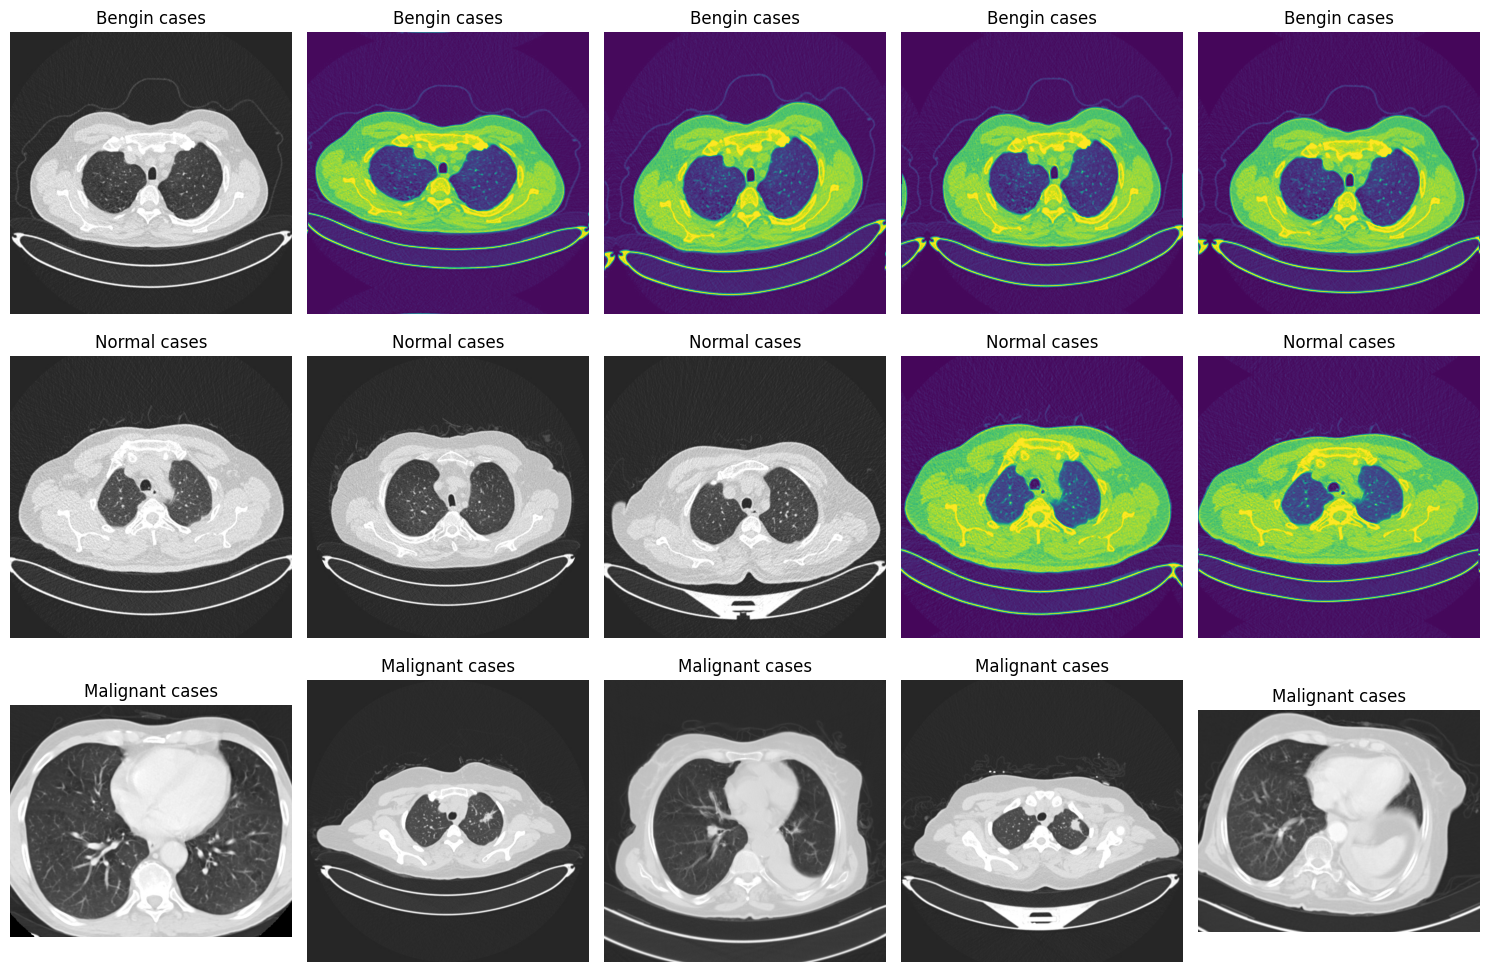

In [ ]:
import seaborn as sns
from PIL import Image

def visualize_samples(directory, num_samples=5):
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]  # Filter out non-directory entries
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]  # Filter out non-file entries
        images = images[:num_samples]

        for j, image_name in enumerate(images):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images from train directory
visualize_samples(train_output_dir, num_samples=5)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define data generators
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10%
    height_shift_range=0.1,  # Shift images vertically by up to 10%
    shear_range=0.1,  # Shear images by up to 10%
    zoom_range=0.1,  # Zoom in/out on images by up to 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically
    fill_mode='nearest'  # Fill in missing pixels using the nearest value
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_output_dir,
    target_size=(224, 224),  # Adjust according to the input size of the model
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Adjust according to the input size of the model
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust according to the input size of the model
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1176 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


# Dense Net

In [ ]:
# Instantiate the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Add custom output layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 18568259 (70.83 MB)
Trainable params: 17534

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Create checkpoint callback
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = "lung_cancer_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
37/37 [==============================] - 150s 1s/step - loss: 0.4258 - accuracy: 0.8316 - val_loss: 0.8134 - val_accuracy: 0.5610 - lr: 1.0000e-04
Epoch 2/50
37/37 [==============================] - 26s 709ms/step - loss: 0.1968 - accuracy: 0.9260 - val_loss: 0.4012 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 3/50
37/37 [==============================] - 24s 638ms/step - loss: 0.1792 - accuracy: 0.9354 - val_loss: 0.3747 - val_accuracy: 0.8476 - lr: 1.0000e-04
Epoch 4/50
37/37 [==============================] - 26s 687ms/step - loss: 0.1205 - accuracy: 0.9566 - val_loss: 0.4163 - val_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 5/50
37/37 [==============================] - 26s 703ms/step - loss: 0.1082 - accuracy: 0.9558 - val_loss: 0.2540 - val_accuracy: 0.9024 - lr: 1.0000e-04
Epoch 6/50
37/37 [==============================] - 26s 702ms/step - loss: 0.0916 - accuracy: 0.9651 - val_loss: 0.3522 - val_accuracy: 0.9085 - lr: 1.0000e-04
Epoch 7/50
37/37 [========================

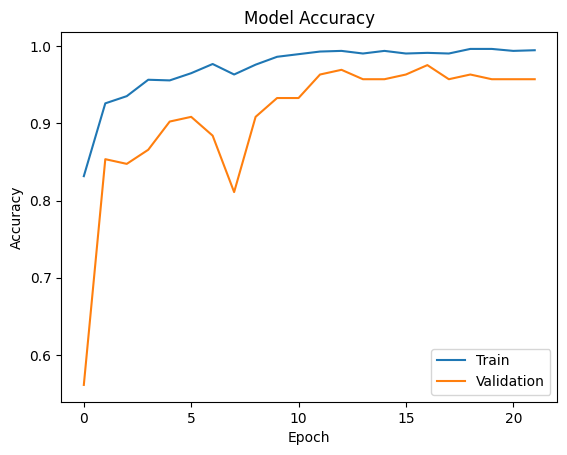

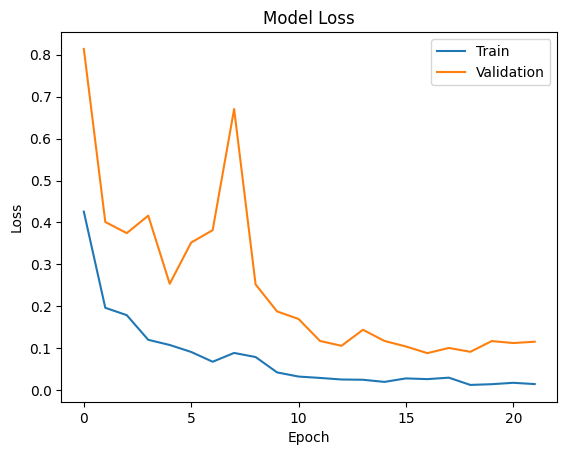

In [ ]:
# Plot model training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

6/6 [==============================] - 9s 1s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       1.00      0.99      0.99        85
           2       0.97      0.92      0.94        63

    accuracy                           0.96       166
   macro avg       0.91      0.95      0.93       166
weighted avg       0.96      0.96      0.96       166



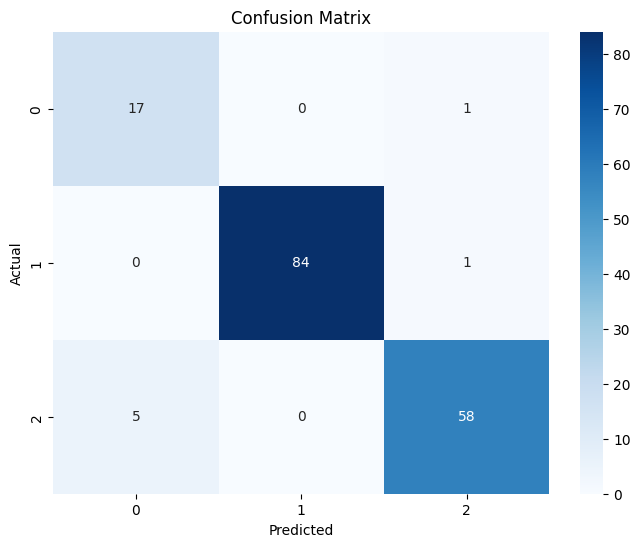

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on validation data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Calculate performance metrics
report = classification_report(test_true_labels, test_pred_labels)
conf_mat = confusion_matrix(y_true=test_true_labels, y_pred=test_pred_labels)

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Effiecent Net

In [ ]:
# Decrease the batch size
batch_size = 16  # You can adjust this value as needed
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1176 images belonging to 3 classes.
Found 164 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers


# Instantiate the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=(256,256,3),
                            classes= 3)

# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create a new model on top of EfficientNetB0
model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model2.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 8, 8, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               327808    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                     

In [ ]:
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model2.fit(
    train_generator,
    epochs=50,
    batch_size = 32,
    validation_data=val_generator,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
74/74 [==============================] - 183s 962ms/step - loss: 0.7014 - accuracy: 0.7168 - val_loss: 1.0372 - val_accuracy: 0.3963 - lr: 1.0000e-04
Epoch 2/50
74/74 [==============================] - 63s 850ms/step - loss: 0.3922 - accuracy: 0.8546 - val_loss: 0.9737 - val_accuracy: 0.5061 - lr: 1.0000e-04
Epoch 3/50
74/74 [==============================] - 63s 844ms/step - loss: 0.3391 - accuracy: 0.8724 - val_loss: 0.5317 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 4/50
74/74 [==============================] - 63s 849ms/step - loss: 0.2989 - accuracy: 0.8903 - val_loss: 0.3856 - val_accuracy: 0.8171 - lr: 1.0000e-04
Epoch 5/50
74/74 [==============================] - 63s 845ms/step - loss: 0.2792 - accuracy: 0.8903 - val_loss: 0.3440 - val_accuracy: 0.8476 - lr: 1.0000e-04
Epoch 6/50
74/74 [==============================] - 63s 848ms/step - loss: 0.2127 - accuracy: 0.9218 - val_loss: 0.2766 - val_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 7/50
74/74 [=====================

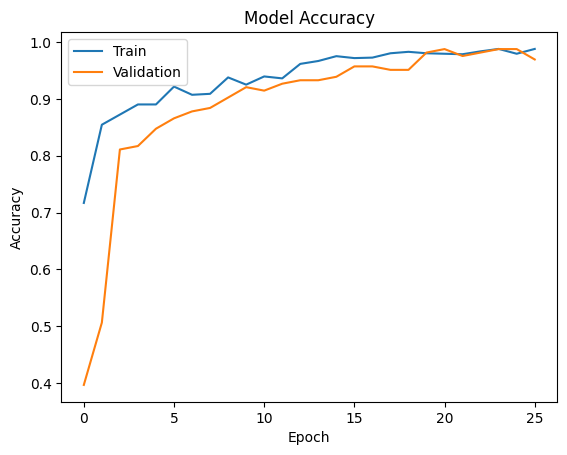

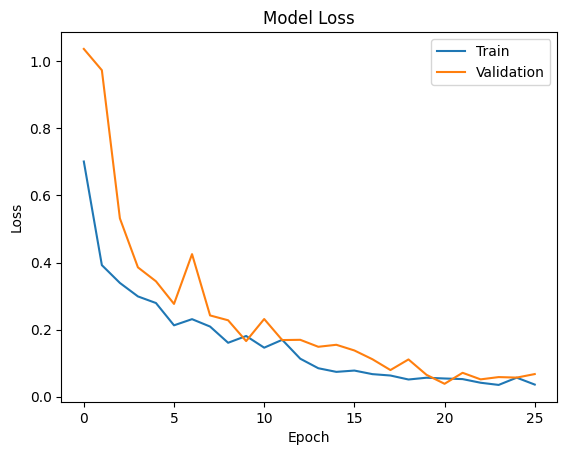

In [ ]:
# Plot model training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

6/6 [==============================] - 11s 576ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       1.00      0.96      0.98        85
           2       0.95      0.97      0.96        63

    accuracy                           0.96       166
   macro avg       0.93      0.96      0.95       166
weighted avg       0.97      0.96      0.96       166



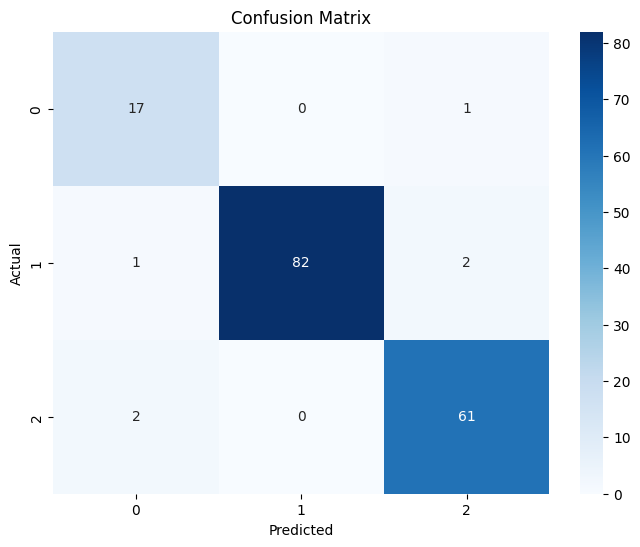

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on validation data
test_predictions = model2.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Calculate performance metrics
report = classification_report(test_true_labels, test_pred_labels)
conf_mat = confusion_matrix(y_true=test_true_labels, y_pred=test_pred_labels)

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# VGG 16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Instantiate the VGG16 model
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(256, 256, 3))

# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all layers before the fine-tune starting layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create a new model on top of VGG16
model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model3.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 660

In [ ]:

model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:


# Train the model
history = model3.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)


Epoch 1/50
74/74 [==============================] - 32s 363ms/step - loss: 1.2622 - accuracy: 0.3197 - val_loss: 1.0491 - val_accuracy: 0.5671 - lr: 1.0000e-04
Epoch 2/50
74/74 [==============================] - 23s 314ms/step - loss: 1.1422 - accuracy: 0.3597 - val_loss: 1.0274 - val_accuracy: 0.6280 - lr: 1.0000e-04
Epoch 3/50
74/74 [==============================] - 24s 318ms/step - loss: 1.0790 - accuracy: 0.4107 - val_loss: 0.9788 - val_accuracy: 0.6829 - lr: 1.0000e-04
Epoch 4/50
74/74 [==============================] - 24s 319ms/step - loss: 1.0231 - accuracy: 0.4855 - val_loss: 0.9400 - val_accuracy: 0.6890 - lr: 1.0000e-04
Epoch 5/50
74/74 [==============================] - 23s 303ms/step - loss: 0.9729 - accuracy: 0.5485 - val_loss: 0.9316 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 6/50
74/74 [==============================] - 24s 320ms/step - loss: 0.9334 - accuracy: 0.6088 - val_loss: 0.8892 - val_accuracy: 0.7195 - lr: 1.0000e-04
Epoch 7/50
74/74 [======================

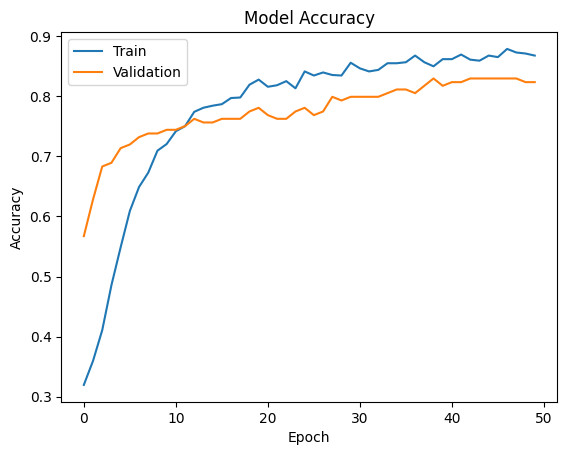

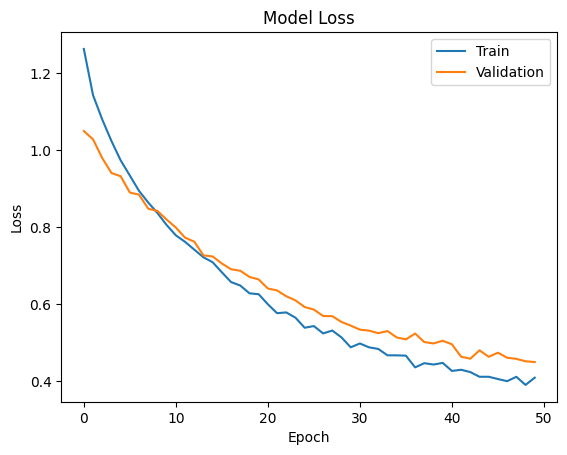

In [ ]:
# Plot model training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

6/6 [==============================] - 9s 487ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.22      0.24        18
           1       0.97      0.78      0.86        85
           2       0.67      0.89      0.77        63

    accuracy                           0.76       166
   macro avg       0.64      0.63      0.62       166
weighted avg       0.78      0.76      0.76       166



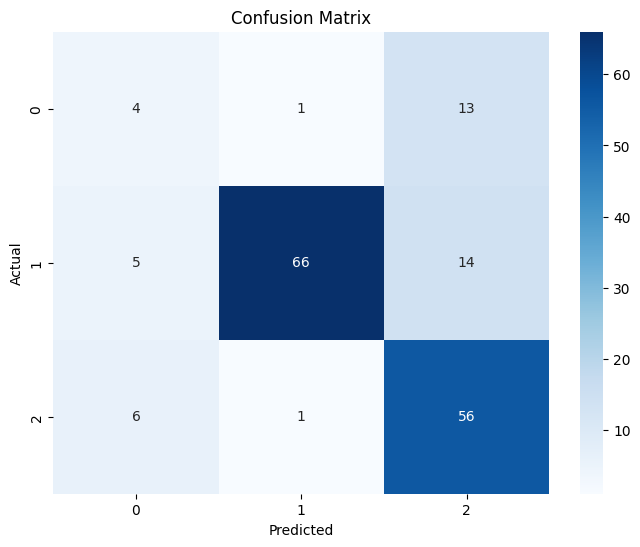

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluate model on validation data
test_predictions = model3.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)  # Update variable name here
test_true_labels = test_generator.classes  # Use test_generator.classes for true labels

# Calculate performance metrics
report = classification_report(test_true_labels, test_pred_labels)
conf_mat = confusion_matrix(y_true=test_true_labels, y_pred=test_pred_labels)

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Ensemble Learning

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Assuming you have test data and corresponding labels
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust according to the input size of the model
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate models on test data
test_predictions1 = model.predict(test_generator)
test_predictions2 = model2.predict(test_generator)
test_predictions3 = model3.predict(test_generator)

# Calculate accuracy for each model
test_accuracy1 = accuracy_score(test_generator.classes, np.argmax(test_predictions1, axis=1))
test_accuracy2 = accuracy_score(test_generator.classes, np.argmax(test_predictions2, axis=1))
test_accuracy3 = accuracy_score(test_generator.classes, np.argmax(test_predictions3, axis=1))

# Normalize performance metrics
total_accuracy = test_accuracy1 + test_accuracy2 + test_accuracy3
weight1 = test_accuracy1 / total_accuracy
weight2 = test_accuracy2 / total_accuracy
weight3 = test_accuracy3 / total_accuracy

Found 166 images belonging to 3 classes.
11/11 [==============================] - 1s 97ms/step


In [ ]:
# Print weights
print("Weights for model1, model2, and model3 respectively:", weight1, weight2, weight3)


Weights for model1, model2, and model3 respectively: 0.35730337078651686 0.3595505617977528 0.28314606741573034


In [ ]:
# Calculate weighted ensemble predictions
ensemble_predictions = (weight1 * test_predictions1) + (weight2 * test_predictions2) + (weight3 * test_predictions3)

# Convert ensemble predictions to class labels
ensemble_pred_labels = np.argmax(ensemble_predictions, axis=1)

# Get true labels from the test generator
test_true_labels = test_generator.classes

# Calculate accuracy of the weighted ensemble
ensemble_test_accuracy = accuracy_score(test_true_labels, ensemble_pred_labels)
print("Weighted Ensemble Test Accuracy:", ensemble_test_accuracy)

Weighted Ensemble Test Accuracy: 0.9819277108433735


In [ ]:
# Calculate confusion matrix
conf_mat = confusion_matrix(test_true_labels, ensemble_pred_labels)
print("\nConfusion Matrix:")
print(conf_mat)



Confusion Matrix:
[[17  0  1]
 [ 0 84  1]
 [ 1  0 62]]


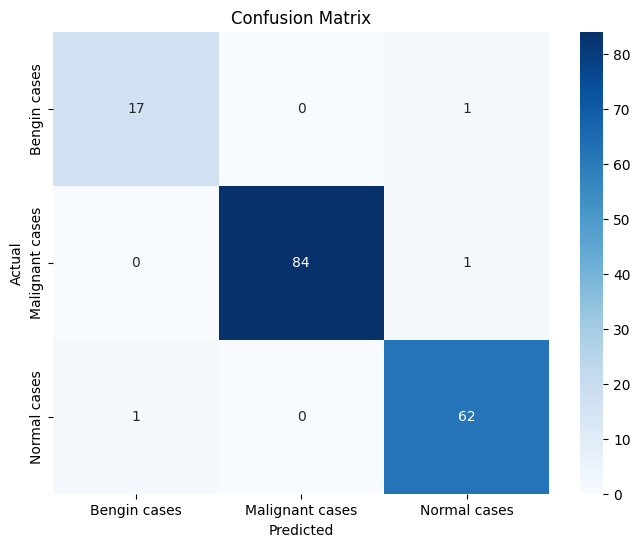

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate classification report for the ensemble
ensemble_classification_report = classification_report(test_true_labels, ensemble_pred_labels)
print("\nClassification Report for Weighted Ensemble:")
print(ensemble_classification_report)


Classification Report for Weighted Ensemble:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       1.00      0.99      0.99        85
           2       0.97      0.98      0.98        63

    accuracy                           0.98       166
   macro avg       0.97      0.97      0.97       166
weighted avg       0.98      0.98      0.98       166



In [ ]:
# Evaluate models on test data
test_predictions1 = model.predict(test_generator)
test_predictions2 = model2.predict(test_generator)
test_predictions3 = model3.predict(test_generator)
# Calculate accuracy for each model
test_accuracy1 = accuracy_score(test_generator.classes, np.argmax(test_predictions1, axis=1))
test_accuracy2 = accuracy_score(test_generator.classes, np.argmax(test_predictions2, axis=1))
test_accuracy3 = accuracy_score(test_generator.classes, np.argmax(test_predictions3, axis=1))

# Define metrics for comparison
models = ['DenseNet', 'EfficientNet', 'VGG16', 'Ensemble']
accuracies = [test_accuracy1, test_accuracy2, test_accuracy3, ensemble_test_accuracy]




11/11 [==============================] - 1s 69ms/step


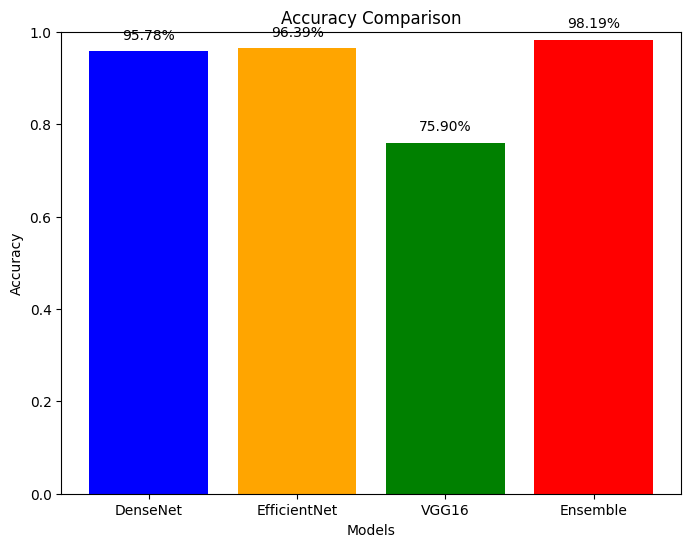

In [ ]:
# Plot comparison graph
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add percentage labels on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{acc:.2%}', ha='center', va='bottom')

plt.show()